In [1]:
from math import pi
import numpy
%matplotlib inline
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numba
from numba import jit

In [2]:
def plot_3D(x,y,u):    
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,u[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u$')
    ax.view_init(30,45)

In [3]:
def poisson_initial(ni,nj):
    u0=numpy.random.random((nj,ni))
    x=numpy.linspace(0,1,ni)
    y=numpy.linspace(0,1,nj)
    plot_3D(x,y,u0)
    return u0

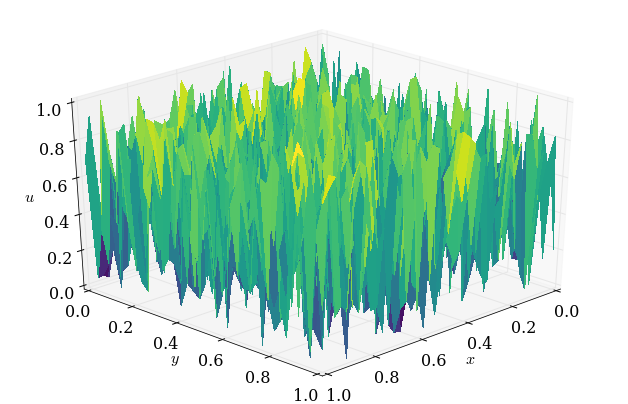

In [4]:
u0=poisson_initial(41,41)

In [5]:
@jit
def jacobi(ni,nj,n,res_target):
    x=numpy.linspace(0,1,ni)
    y=numpy.linspace(0,1,nj)
    dx=1./(ni-1)
    dy=1./(nj-1)
    X,Y=numpy.meshgrid(x,y)
    f=-2*(2*pi*n)**2*numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    u_ex=numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    u0=numpy.random.random((nj,ni))
    u=u0.copy()
    u[0,:]=u_ex[0,:]
    u[-1,:]=u[-2,:]
    u[:,0]=u[:,1]
    u[:,-1]=u[:,-2]
    iterations=0
    dif=numpy.zeros((nj,ni))
    err=numpy.zeros((nj,ni))
    res=numpy.zeros((nj,ni))
    res_max=1e3
    while res_max>res_target:
        uold=u.copy()
        u[1:-1,1:-1]=1/(2*(dx**2+dy**2))*((uold[1:-1,2:]+uold[1:-1,:-2])*dy**2+\
                     (uold[2:,1:-1]+uold[:-2,1:-1])*dx**2-f[1:-1,1:-1]*dx**2*dy**2)
        #for j in range(1,nj-1):
            #for i in range(1,ni-1):
                #u[j,i]=1./(2*(dx**2+dy**2))*((uold[j,i+1]+uold[j,i-1])*dy**2+\
                       #(uold[j+1,i]+uold[j-1,i])*dx**2-f[j,i]*dx**2*dy**2)
        u[0,:]=u_ex[0,:]
        u[-1,:]=u[-2,:]
        u[:,0]=u[:,1]
        u[:,-1]=u[:,-2]

        for j in range(1,nj-1):
            for i in range(1,ni-1):
                res[j,i]=numpy.abs(f[j,i]-(u[j,i-1]-2*u[j,i]+u[j,i+1])/dx**2-\
                                  (u[j-1,i]-2*u[j,i]+u[j+1,i])/dy**2)
        res_max=numpy.max(res)
    
        iterations+=1
        
    for j in range(nj):
        for i in range(ni):
            dif[j,i]=numpy.abs(u[j,i]-uold[j,i])
            err[j,i]=numpy.abs(u[j,i]-u_ex[j,i])
    
    dif_max=numpy.max(dif)
    err_max=numpy.max(err)
    
    A=numpy.array([u,x,y,dif_max,err_max,res_max,iterations])
    return A

In [6]:
@jit
def SOR(ni,nj,n,res_target,omega):
    x=numpy.linspace(0,1,ni)
    y=numpy.linspace(0,1,nj)
    dx=1./(ni-1)
    dy=1./(nj-1)
    X,Y=numpy.meshgrid(x,y)
    f=-2*(2*pi*n)**2*numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    u_ex=numpy.cos(2*pi*n*X)*numpy.cos(2*pi*n*Y)
    u0=numpy.random.random((nj,ni))
    u=u0.copy()
    u[0,:]=u_ex[0,:]
    u[-1,:]=u[-2,:]
    u[:,0]=u[:,1]
    u[:,-1]=u[:,-2]
    dif=numpy.zeros((nj,ni))
    err=numpy.zeros((nj,ni))
    res=numpy.zeros((nj,ni))
    res_max=1e3
    iterations=0
    
    while res_max>res_target:
        uold=u.copy()
        for j in range(1,nj-1):
            for i in range(1,ni-1):
                u[j,i]=omega/(2*(dx**2+dy**2))*((u[j,i-1]+u[j,i+1])*dy**2+\
                       (u[j-1,i]+u[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+\
                       (1-omega)*u[j,i]
                    
        u[0,:]=u_ex[0,:]
        u[-1,:]=u[-2,:]
        u[:,0]=u[:,1]
        u[:,-1]=u[:,-2]
        
        for j in range(1,nj-1):
            for i in range(1,ni-1):
                res[j,i]=numpy.abs(f[j,i]-(u[j,i-1]-2*u[j,i]+u[j,i+1])/dx**2-\
                                  (u[j-1,i]-2*u[j,i]+u[j+1,i])/dy**2)
        res_max=numpy.max(res)
        
        iterations+=1
        
    for j in range(nj):
        for i in range(ni):
            dif[j,i]=numpy.abs(u[j,i]-uold[j,i])
            err[j,i]=numpy.abs(u[j,i]-u_ex[j,i])
    
    dif_max=numpy.max(dif)
    err_max=numpy.max(err)
    
    A=numpy.array([u,x,y,dif_max,err_max,res_max,iterations])
    
    return A

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


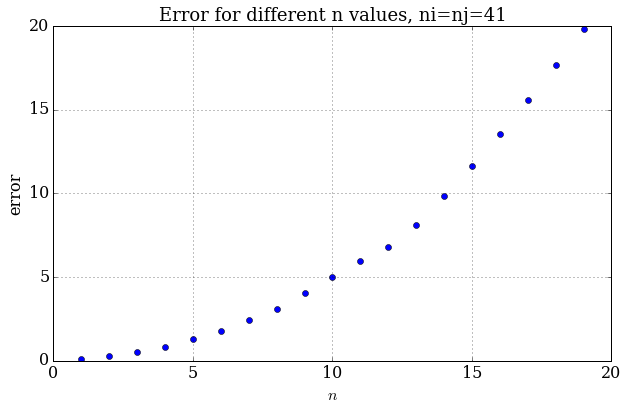

In [7]:
error40_jac=[]
for k in range(1,20):
    error40_jac.append(jacobi(41,41,k,1e-9)[4])
    
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$n$')
pyplot.ylabel('error')
pyplot.plot(numpy.linspace(1,19,19),error40_jac,'o')
pyplot.title('Error for different n values, ni=nj=41',fontsize=18)
pyplot.legend()

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


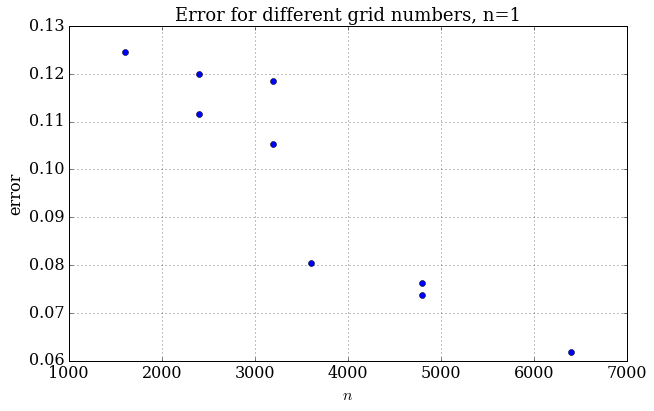

In [10]:
error_grid_jac=[]
ninj=[]
for ni in range(40,81,20):
    for nj in range(40,81,20):
        error_grid_jac.append(jacobi(ni,nj,1,1e-9)[4])
        ninj.append(ni*nj)
        
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$n$')
pyplot.ylabel('error')
pyplot.plot(ninj,error_grid_jac,'o')
pyplot.title('Error for different grid numbers, n=1',fontsize=18)
pyplot.legend()

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


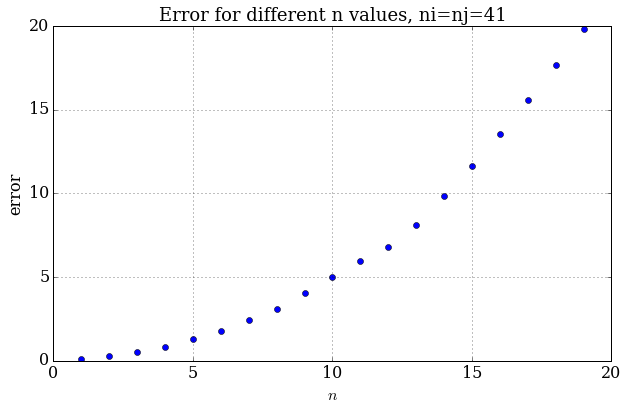

In [11]:
error40_SOR=[]
for k in range(1,20):
    error40_SOR.append(SOR(41,41,k,1e-9,1.9)[4])
    
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$n$')
pyplot.ylabel('error')
pyplot.plot(numpy.linspace(1,19,19),error40_jac,'o')
pyplot.title('Error for different n values, ni=nj=41',fontsize=18)
pyplot.legend()

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


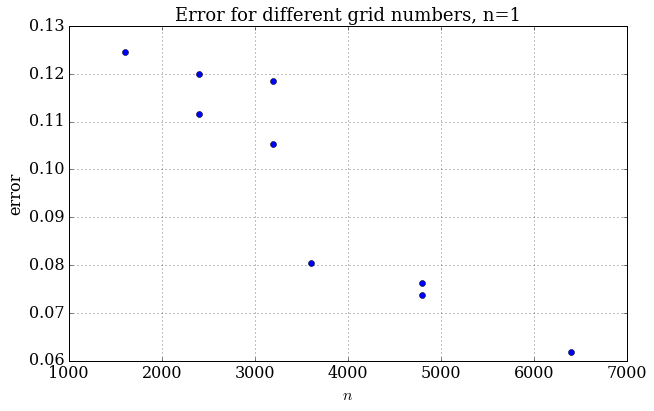

In [12]:
error_grid_SOR=[]
ninj=[]
for ni in range(40,81,20):
    for nj in range(40,81,20):
        error_grid_SOR.append(SOR(ni,nj,1,1e-9,1.9)[4])
        ninj.append(ni*nj)
        
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$n$')
pyplot.ylabel('error')
pyplot.plot(ninj,error_grid_jac,'o')
pyplot.title('Error for different grid numbers, n=1',fontsize=18)
pyplot.legend()

In [ ]:
u_jac1,x_jac1,y_jac1,dif_jac1,err_jac1,res_jac1,iterations_jac1=jacobi(41,41,1,1e-9)
plot_3D(x_jac1,y_jac1,u_jac1)
print('dif_jacobi1={}'.format(dif_jac1))
print('err_jacobi1={}'.format(err_jac1))
print('res_jacobi1={}'.format(res_jac1))
print('iterations_jacobi1={}'.format(iterations_jac1))

In [ ]:
u_jac2,x_jac2,y_jac2,dif_jac2,err_jac2,res_jac2,iterations_jac2=jacobi(41,41,2,1e-9)
plot_3D(x_jac2,y_jac2,u_jac2)
print('dif_jacobi2={}'.format(dif_jac2))
print('err_jacobi2={}'.format(err_jac2))
print('res_jacobi2={}'.format(res_jac2))
print('iterations_jacobi2={}'.format(iterations_jac2))

In [ ]:
u_jac3,x_jac3,y_jac3,dif_jac3,err_jac3,res_jac3,iterations_jac3=jacobi(41,41,3,1e-9)
plot_3D(x_jac3,y_jac3,u_jac3)
print('dif_jacobi3={}'.format(dif_jac3))
print('err_jacobi3={}'.format(err_jac3))
print('res_jacobi3={}'.format(res_jac3))
print('iterations_jacobi3={}'.format(iterations_jac3))

dif_SOR1=3.7470027081099033e-13
err_SOR1=0.12111995892722338
res_SOR1=9.980496429307095e-10
iterations_SOR1=9927


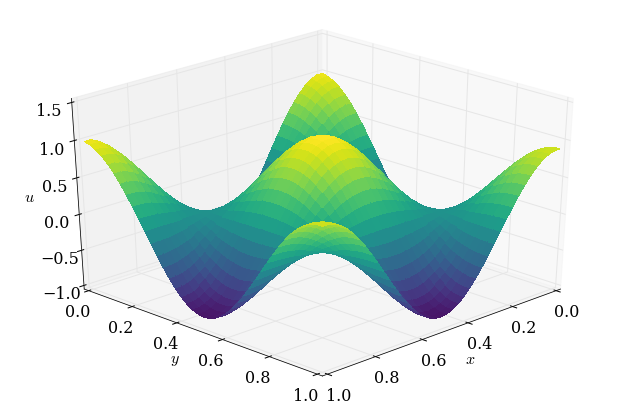

In [17]:
u_SOR1,x_SOR1,y_SOR1,dif_SOR1,err_SOR1,res_SOR1,iterations_SOR1=SOR(41,41,1,1e-9,1.5)
plot_3D(x_SOR1,y_SOR1,u_SOR1)
print('dif_SOR1={}'.format(dif_SOR1))
print('err_SOR1={}'.format(err_SOR1))
print('res_SOR1={}'.format(res_SOR1))
print('iterations_SOR1={}'.format(iterations_SOR1))

dif_SOR2=5.684341886080801e-13
err_SOR2=0.28444931424437014
res_SOR2=9.97204097075155e-10
iterations_SOR2=2218


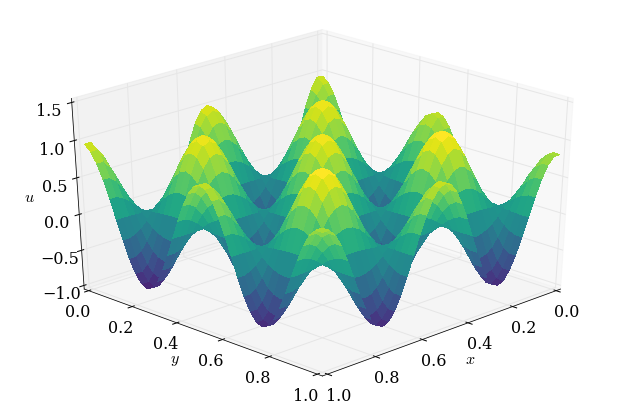

In [18]:
u_SOR2,x_SOR2,y_SOR2,dif_SOR2,err_SOR2,res_SOR2,iterations_SOR2=SOR(41,41,2,1e-9,1.9)
plot_3D(x_SOR2,y_SOR2,u_SOR2)
print('dif_SOR2={}'.format(dif_SOR2))
print('err_SOR2={}'.format(err_SOR2))
print('res_SOR2={}'.format(res_SOR2))
print('iterations_SOR2={}'.format(iterations_SOR2))

dif_SOR3=3.750333377183779e-13
err_SOR3=0.5192459922495593
res_SOR3=9.983409654523712e-10
iterations_SOR3=9791


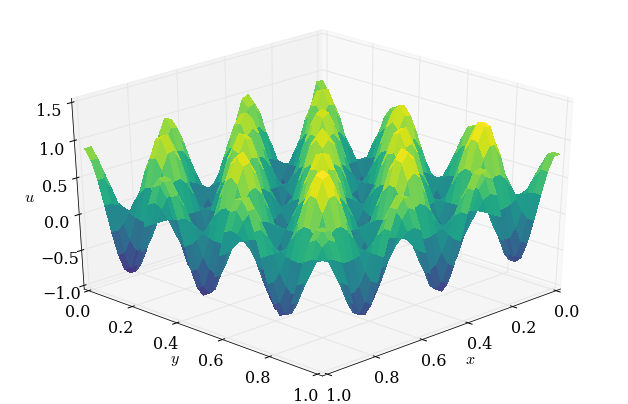

In [19]:
u_SOR3,x_SOR3,y_SOR3,dif_SOR3,err_SOR3,res_SOR3,iterations_SOR3=SOR(41,41,3,1e-9,1.5)
plot_3D(x_SOR3,y_SOR3,u_SOR3)
print('dif_SOR3={}'.format(dif_SOR3))
print('err_SOR3={}'.format(err_SOR3))
print('res_SOR3={}'.format(res_SOR3))
print('iterations_SOR3={}'.format(iterations_SOR3))

dif_SOR5=3.750333377183779e-13
err_SOR5=1.278495857008685
res_SOR5=9.988525562221184e-10
iterations_SOR5=8923


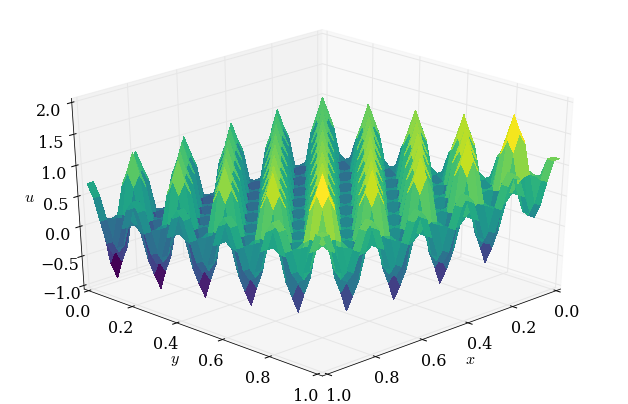

In [20]:
u_SOR5,x_SOR5,y_SOR5,dif_SOR5,err_SOR5,res_SOR5,iterations_SOR5=SOR(41,41,5,1e-9,1.5)
plot_3D(x_SOR5,y_SOR5,u_SOR5)
print('dif_SOR5={}'.format(dif_SOR5))
print('err_SOR5={}'.format(err_SOR5))
print('res_SOR5={}'.format(res_SOR5))
print('iterations_SOR5={}'.format(iterations_SOR5))

In [21]:
u_SOR10,x_SOR10,y_SOR10,dif_SOR10,err_SOR10,res_SOR10,iterations_SOR10=SOR(41,41,10,1e-9,1.9)

print('dif_SOR10={}'.format(dif_SOR10))
print('err_SOR10={}'.format(err_SOR10))
print('res_SOR10={}'.format(res_SOR10))
print('iterations_SOR10={}'.format(iterations_SOR10))

dif_SOR10=5.666578317686799e-13
err_SOR10=5.034707559161143
res_SOR10=9.929408406605944e-10
iterations_SOR10=2359


In [22]:
numpy.max(u_SOR10)

4.8262992156012787